# Sampling implementation tests

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import time
from planar_ising import PlanarIsingModelGenerator, InferenceAndSampling, PlanarIsingModel

np.random.seed(42)

# Problem statement

Let $V = \{ 1, ..., N \}, E \subseteq \binom{V}{2}, G = (V, E)$ be an undirected planar graph. For each $v \in V$ we assign a random binary variable (a spin) $s_v \in \{ -1, +1 \}$, $S = (s_1, ..., s_N)$. For each $e \in E$ we define a number $J_e \in \mathbb{R}$. We define a probability of the assignment $X = (x_1, ..., x_N) \in \{ -1, +1 \}^N$ as follows:

\begin{equation}
\mathbb{P} (S = X) = \frac{1}{Z} \exp{ \sum_{e = \{i, j\} \in E} J_e x_i x_j }
\label{eq:distr}
\end{equation}

Where

\begin{equation}
Z = \sum_{X \in \{ -1, +1 \}^N} \exp{ \sum_{e = \{i, j\} \in E} J_e x_i x_j }
\end{equation}

Given $G$'s plane embedding and a set of $J_e$, a goal is to draw samples from $\mathbb{P}(S = X)$ efficiently.

We will test two slightly different inference/sampling algorithms - `EfficientInferenceAndSampling` and `WilsonInferenceAndSampling`. Both are numerically correct, but the first one tends to draw samples faster on practice.

In all the experiments conducted further we work with the following model generating parameters (check `PlanarIsingModelGenerator` docstrings):

In [2]:
graph_density = 1.0
interaction_values_std = 0.1

# Validation of sampling routine

It appears that having a sample $D = \{ (X_1, m_{X_1}), ..., (X_m, m_{X_m}) \}$ ($\{ X_i \}$ are distinct, $X_i$ enters sample $m_{X_i}$ times, $m_{X} = 0$ for $X$ not in sample) of spin configurations drawn from the distribution $\mathbb{P}(S = X)$, the $L_2$ error $\alpha$ between discrete distribution $\mathbb{P}(S = X)$ and empirical distribution $\mathbb{P}_{emp} (S = X) = \frac{m_X}{\sum_{i = 1}^m m_{X_i}}$ can be computed analytically. Indeed,

\begin{equation}
\begin{aligned}
\alpha^2 &= \sum_{X} (\mathbb{P}(S = X) - \mathbb{P}_{emp}(S = X))^2 \\
	&= \sum_{X \in D} (\mathbb{P}(S = X) - \mathbb{P}_{emp}(S = X))^2 + \sum_{X \notin D} (\mathbb{P}(S = X) - \mathbb{P}_{emp}(S = X))^2 \\
    &= \sum_{X \in D} (\mathbb{P}(S = X) - \mathbb{P}_{emp}(S = X))^2 + \sum_{X \notin D} \mathbb{P}(S = X)^2 \\
    &= \sum_{X \in D} (\mathbb{P}(S = X) - \mathbb{P}_{emp}(S = X))^2 + \sum_{X \notin D} \frac{1}{Z^2} \exp{ 2 \sum_{e = \{i, j\} \in E} J_e x_i x_j } \\
    &= \sum_{X \in D} (\mathbb{P}(S = X) - \mathbb{P}_{emp}(S = X))^2 + \sum_{X \notin D} \frac{1}{Z^2} \exp{ \sum_{e = \{i, j\} \in E} (2 J_e) x_i x_j } \\
    &= \sum_{X \in D} (\mathbb{P}(S = X) - \mathbb{P}_{emp}(S = X))^2 + \frac{Z_2}{Z^2} - \sum_{X \in D} \frac{1}{Z^2} \exp{ \sum_{e = \{i, j\} \in E} (2 J_e) x_i x_j }
\label{eq:dist}
\end{aligned}
\end{equation}

where $Z_2$ is a partition function value associated with Ising Model on the same graph $G$ but with interaction values equal to $\{ 2J_e\}_{e \in E}$. Since we have implemented and tested partition function computation independently (check [notebook](https://github.com/ValeryTyumen/planar_ising/blob/master/tests/inference_tests.ipynb)), we can assume that we can compute $Z$ and $Z_2$ exactly. Two other sum terms in the formula are computed by one pass through the sample.

Showing that $\alpha$ approaches zero with the growth of sample size, we assure that our algorithm produces correct samples from $\mathbb{P}(S = X)$.

The next method implements empirical distribution L2 error for a given model and sample size.

In [3]:
def compute_l2_error_between_empirical_and_theoretical_distribution(ising_model,
        sampled_configurations):

    sample_size = len(sampled_configurations)

    inference_and_sampling = InferenceAndSampling(ising_model)
    inference_and_sampling.prepare()
    log_partition_function = inference_and_sampling.compute_logpf()

    ising_model_doubled_interactions = PlanarIsingModel(ising_model.graph,
            2*ising_model.interaction_values)
    inference_doubled_interactions = InferenceAndSampling(ising_model_doubled_interactions)
    inference_doubled_interactions.prepare()
    log_partition_function_doubled_interactions = \
            inference_doubled_interactions.compute_logpf()

    l2_error_squared = np.exp(log_partition_function_doubled_interactions - \
            2*log_partition_function)

    configuration_statistics = {}

    for configuration in sampled_configurations:

        configuration_index = \
                (configuration + 1).dot(2**np.arange(ising_model.graph.size))//2

        if configuration_index not in configuration_statistics:

            minus_energy = ising_model.get_minus_energy(configuration)
            minus_energy_doubled_interactions = \
                    ising_model_doubled_interactions.get_minus_energy(configuration)

            configuration_statistics[configuration_index] = (1, minus_energy, \
                    minus_energy_doubled_interactions)

        else:

            configuration_statistics[configuration_index] = \
                    (configuration_statistics[configuration_index][0] + 1,
                     configuration_statistics[configuration_index][1],
                     configuration_statistics[configuration_index][2])

    for frequency, minus_energy, \
            minus_energy_doubled_interactions in configuration_statistics.values():

        l2_error_squared -= np.exp(minus_energy_doubled_interactions - \
                2*log_partition_function)
        l2_error_squared += (np.exp(minus_energy - log_partition_function) - \
                frequency/sample_size)**2

    return np.sqrt(l2_error_squared)

Now let's generate 3 Planar Ising Models of different scale and plot behaviour of $\alpha$ depending on sample size. Evident convergence to zero proves correctness of the sampling routine.

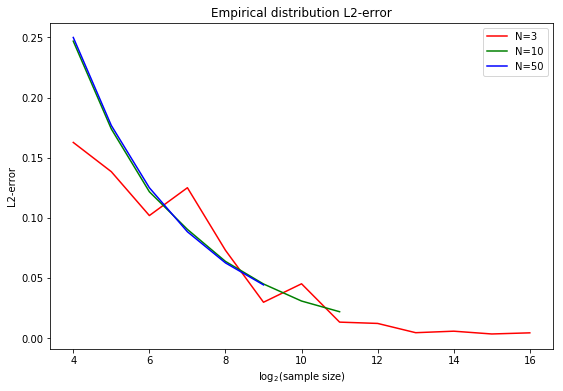

In [4]:
plt.figure(figsize=(9, 6))

graph_sizes = [3, 10, 50]
log2_samples_sizes_per_graph_size = [np.arange(4, 17), np.arange(4, 12),
                                     np.arange(4, 10)]

for graph_size, log2_sample_sizes, color in zip(graph_sizes, log2_samples_sizes_per_graph_size,
                                                ['r', 'g', 'b']):

    ising_model = PlanarIsingModelGenerator.generate_random_model(graph_size,
            graph_density, interaction_values_std)

    sampling = InferenceAndSampling(ising_model)
    sampling.prepare(sampling=True)
    
    l2_errors = []

    for log2_sample_size in log2_sample_sizes:

        sample_size = 2**log2_sample_size

        sampled_configurations = sampling.sample_spin_configurations(sample_size)

        l2_error = compute_l2_error_between_empirical_and_theoretical_distribution(
                ising_model, sampled_configurations)

        l2_errors.append(l2_error)
            
    plt.plot(log2_sample_sizes, l2_errors, color, label='N={}'.format(graph_size))

plt.title('Empirical distribution L2-error')
plt.xlabel('$\log_2$(sample size)')
plt.ylabel('L2-error')
plt.legend()

plt.show()

# Execution time

The next plot shows time complexity of preprocessing and sampling steps depending on the size of the model. Each point of the scatter plot corresponds to the random Ising model of the given size. Logarithmic axes unveil solid $O(N^{\frac32})$ complexity of both preprocessing and sampling. The maximal model size exposed on the plot is $4096$, which speaks of framework scalability potential.

In [6]:
log2_graph_sizes = np.arange(2, 13)
samples_count = 5

log2_graph_sizes_per_sample = []
preprocessing_times_per_sample = []
sampling_times_per_sample = []

for log2_graph_size in log2_graph_sizes:

    graph_size = 2**log2_graph_size

    for sample_index in range(samples_count):

        log2_graph_sizes_per_sample.append(log2_graph_size)

        ising_model = PlanarIsingModelGenerator.generate_random_model(graph_size,
                graph_density, interaction_values_std)

        start_moment = time.time()
        sampling = InferenceAndSampling(ising_model)
        sampling.prepare(sampling=True)
        preprocessing_time = time.time() - start_moment

        start_moment = time.time()
        sampling.sample_spin_configurations(1)
        sampling_time = time.time() - start_moment

        preprocessing_times_per_sample.append(preprocessing_time)
        sampling_times_per_sample.append(sampling_time)

    if log2_graph_size > 8:
        print('Done with size {}'.format(graph_size))

Done with size 512
Done with size 1024
Done with size 2048
Done with size 4096


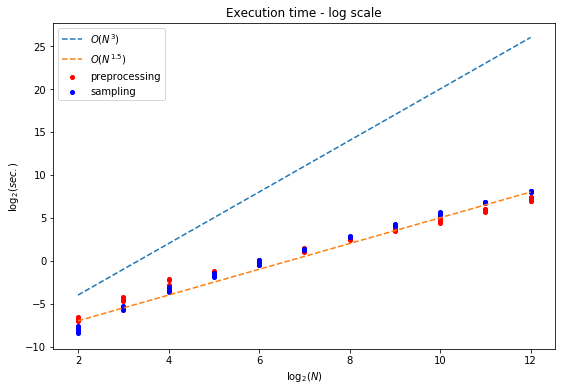

In [7]:
plt.figure(figsize=(9, 6))

plt.scatter(log2_graph_sizes_per_sample, np.log2(preprocessing_times_per_sample),
        c='r', s=16, label='preprocessing')

plt.scatter(log2_graph_sizes_per_sample, np.log2(sampling_times_per_sample),
        c='b', s=16, label='sampling')

plt.plot(log2_graph_sizes, 3*log2_graph_sizes - 10, '--', label='$O(N^3)$')
plt.plot(log2_graph_sizes, 1.5*log2_graph_sizes - 10, '--', label='$O(N^{1.5})$')

plt.title('Execution time - log scale')
plt.xlabel('$\log_2 (N)$')
plt.ylabel('$\log_2 (sec.)$')
plt.legend()

plt.show()